In [1]:
import os
import shutil
from time import time
import tracemalloc

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf

import keras_tuner
from keras import layers, models, regularizers

from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.metrics import roc_curve

from IPython import display
import pyaudio

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Importing Dataset

For the data, we have 8 folders, one for each label, containing 3000 audio files each.  
- We now get batches, each of size 64 (one batch contains 64 audio files). 
- The audio files are also normalized to have a sequence length of 16000, since majority of the files contain this length.

In [2]:
#data_dir = 'data\mini_speech_commands'
mini_data_dir = r'E:\Academics\UniPD\Courses\Semester_3\Human Data Analytics\Project\data\mini_speech_commands'
full_data_dir = r'E:\Academics\UniPD\Courses\Semester_3\Human Data Analytics\Project\data\full_speech_commands'

ref0_data_dir = r'E:\Academics\UniPD\Courses\Semester_3\Human Data Analytics\Project\data\ref_speech_commands'
ref1_data_dir = r'E:\Academics\UniPD\Courses\Semester_3\Human Data Analytics\Project\data\ref1_speech_commands'

data_dir = ref0_data_dir

labels = np.array(os.listdir(data_dir))
labels = labels[(labels != 'README.md')]
print(f'Labels: {labels} \n')

for label in labels:
    direct = data_dir + f'\{label}'
    print(f'Audio Files in Folder {label}: {len(os.listdir(direct))}')

Labels: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes'] 

Audio Files in Folder down: 3000
Audio Files in Folder go: 3000
Audio Files in Folder left: 3000
Audio Files in Folder no: 3000
Audio Files in Folder right: 3000
Audio Files in Folder stop: 3000
Audio Files in Folder up: 3000
Audio Files in Folder yes: 3000


In [3]:
sample_rate = 16000
batch_size = 64         #32
val_test_split = 0.2    #0.3

train_data, val_data = tf.keras.utils.audio_dataset_from_directory(
                            directory=data_dir,
                            batch_size = batch_size,
                            validation_split=val_test_split,
                            seed = 0,
                            output_sequence_length=sample_rate,
                            subset='both')

Found 24000 files belonging to 8 classes.
Using 19200 files for training.
Using 4800 files for validation.


In [4]:
test_data = val_data.shard(num_shards = 2, index = 0)
val_data = val_data.shard(num_shards = 2, index = 1)

#### Shift Files to make dataset

The main dataset (Speech Commands Dataset) contains 30 classes for short speech keywords, each containing 1k-3k number of one-second audio wav files, totalling around 100k files.  Due to hardware contraints, we first optimize on a mini-version of the dataset (1k files each for 8 classes), and derive results using a larger sized dataset (3k files each for 8 classes). 

In the end, we train the best models on a different set of classes to make sure the model is able to train on and learn different settings, and not just the initial 8 classes.

Here, we shift files from the original (large) dataset, filtering for 8 classes, and moving these to the preferred directory.

In [ ]:
#Shifts files from source to destination, choosing a few labels instead of using all 30 labels
def shift_files(source_dir, dest_dir, n_files, labels):

    for label in labels:
        
        #Gets source dir for label
        label_source_dir = source_dir + fr'\{label}'
        
        #Creates directory for label file
        label_dest_dir = dest_dir + fr'\{label}'

        if os.path.exists(label_dest_dir): shutil.rmtree(label_dest_dir)
        os.makedirs(label_dest_dir)

        #Gets files to shift
        print(f'\nFiles in source directory for {label}: {len(os.listdir(label_source_dir))}')
        files = os.listdir(label_source_dir)[:n_files]

        #Copies file from source to destination
        for file_name in files:
            file_path = os.path.join(label_source_dir, file_name)
            if os.path.isfile(file_path): shutil.copy(file_path, label_dest_dir)
            #shutil.copy(file_path, label_dest_dir)
        
        print(f'Finished Copying {len(os.listdir(label_dest_dir))} files for {label}')

In [ ]:
# #ref_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
# ref_labels = ['go', 'no', 'on', 'one', 'bed', 'bird', 'five', 'four']

# shift_files(full_data_dir, ref1_data_dir, n_files = 2000, labels = ref_labels)

#### Shapes of the datasets

In [5]:
#Gets shapes of the data (excluding labels)
def get_shapes(data, return_shape = False):
    print(f'Number of Training Batches: {len(data)}')

    #Getting shape of single batch
    for batch_audio, batch_labels in data:
        break

    print(f'Shape of audio data in batch: {batch_audio.shape}')
    print(f'Shape of labels in batch: {batch_labels.shape}')

    if return_shape: return batch_audio.shape
    return None

In [6]:
get_shapes(train_data)

Number of Training Batches: 300
Shape of audio data in batch: (64, 16000, 1)
Shape of labels in batch: (64,)


In [520]:
get_shapes(val_data)

Number of Training Batches: 12
Shape of audio data in batch: (64, 16000, 1)
Shape of labels in batch: (64,)


In [521]:
get_shapes(test_data)

Number of Training Batches: 13
Shape of audio data in batch: (64, 16000, 1)
Shape of labels in batch: (64,)


#### Confirming equipartition of classes among batches

In [6]:
counts = {i: 0 for i in range(len(labels))}

#Goes through each batch in train_data
for audio_batch, labels_batch in train_data:
    #Gets the counts of unique labels in each batch (64 samples, each corresponding to a label)
    unique_labels, count_labels = np.unique(np.array(labels_batch), return_counts = True)

    for pos in range(len(unique_labels)):
        counts[unique_labels[pos]] += count_labels[pos]

[Text(0.5, 0, '\n Labels'),
 Text(0, 0.5, 'Mean Frequency \n'),
 Text(0.5, 1.0, 'Average Label Occurrence per Batch \n')]

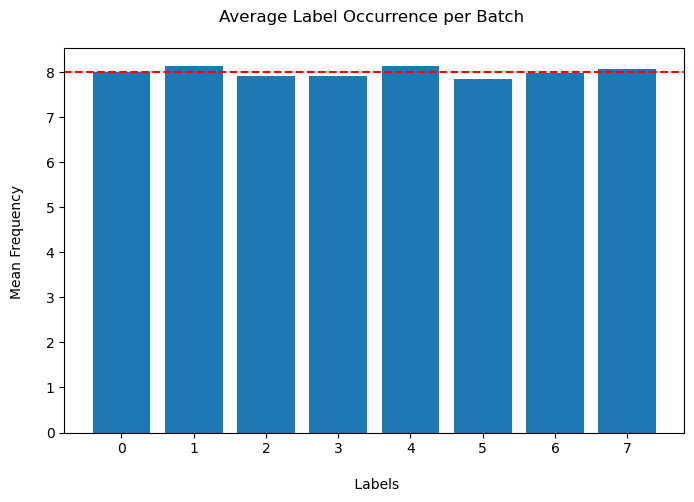

In [508]:
fig, ax = plt.subplots(figsize = (8, 5))

n_batch = len(train_data)


ax.bar(counts.keys(), np.array(list(counts.values())) / n_batch)
ax.axhline(y = 8, color = 'red', linestyle = '--')
ax.set(xlabel = '\n Labels', 
        ylabel = 'Mean Frequency \n', 
        title = 'Average Label Occurrence per Batch \n')

#### Median Sample Rates

We observe that most of the data has a sampling rate of 16000, and thus, we choose this as the standard value throughout our project.

Found 8000 files belonging to 8 classes.
Using 5600 files for training.
Using 2400 files for validation.


<Axes: title={'center': 'Sample rate counts'}, xlabel='sample\xa0rate\xa0[Hz]', ylabel='Frequency'>

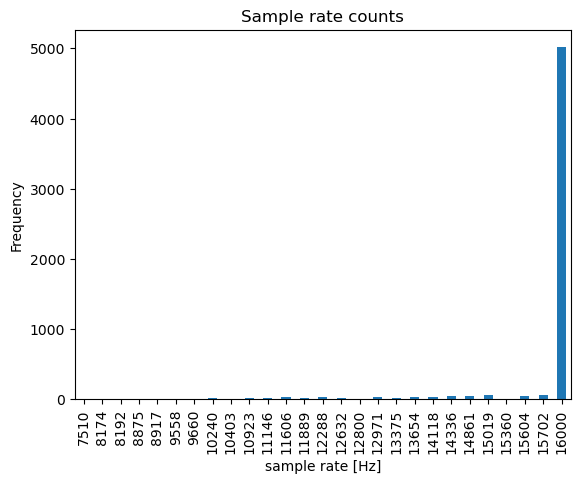

In [509]:
# Sample rate of audio files

# load dataset
train_data_00, val_data_00 = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=1,
    validation_split=0.3,
    seed=0,
    subset='both'
    )

freq_ex = [len(ex[0]) for ex, lab in train_data_00]

# sort values
sorted_list = sorted(freq_ex)

# count repeated values
df_counts = pd.DataFrame(sorted_list, columns=['train_data'])['train_data'].value_counts().sort_index()
df_counts = df_counts[df_counts > 1] #filter out unique ocurrance

# plot frequency of sample rates
df_counts.plot(kind='bar', title='Sample rate counts', ylabel='Frequency', xlabel='sample rate [Hz]')

## Preprocessing Data

#### Reducing Tensor Dimension

The dataset is shaped as (batches, samples, channels).  However, we only have one audio channel here. So, we need to take out the channel dimension.  However, the dataset object consists of both the (data, target).  Thus, we need to separate the data from the target, reduce its dimension and then return in the initial form as (data, target).  

We utilize the map method for doing this.

In [7]:
train_data._structure

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
def squeeze(audio_data, audio_labels):
    audio_data = tf.squeeze(audio_data, axis = -1)
    return audio_data, audio_labels

train_data = train_data.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(squeeze, tf.data.AUTOTUNE)

In [9]:
get_shapes(train_data)

Number of Training Batches: 300
Shape of audio data in batch: (64, 16000)
Shape of labels in batch: (64,)


In [10]:
get_shapes(val_data)

Number of Training Batches: 25
Shape of audio data in batch: (64, 16000)
Shape of labels in batch: (64,)


In [11]:
get_shapes(test_data)

Number of Training Batches: 25
Shape of audio data in batch: (64, 16000)
Shape of labels in batch: (64,)


#### One Hot Encoding Labels

We convert the class labellings to one-hot encoded vectors.  We also define functions that encode and decode these vectors.

In [10]:
encode = layers.CategoryEncoding(num_tokens = len(labels), output_mode = 'one_hot')

train_data = train_data.map(lambda audio, label: (audio, encode(label)))
val_data = val_data.map(lambda audio, label: (audio, encode(label)))
test_data = test_data.map(lambda audio, label: (audio, encode(label)))

In [11]:
for sample_audio, sample_label in train_data:
    break

In [12]:
sample_label[:3]

<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [13]:
get_label_pos = lambda one_hot: np.argwhere(one_hot == 1)[0, 0]
decode_one_hot = lambda arr: np.apply_along_axis(get_label_pos, axis = 1, arr = arr)

decode_one_hot(sample_label[:3])

array([7, 4, 4], dtype=int64)

## Obtaining Datasets: Spectrograms and MFCCs

#### Plotting Waveforms

In [14]:
#Gets a sample audio and corresponding label from training batch
for audio_batch, label_batch in train_data:
    break

In [15]:
def plot_audio(ax, audio, label, ylim = (-1, 1)):

        #Gets the label index from one-hot encoding
        label_value = get_label_pos(label)
        print('Label: ', labels[label_value])

        #Plots the audio and corresponding waveform
        ax.plot(np.array(audio))
        ax.set(title = f'Label: {labels[label_value]}',
                xlabel = '\n Time \n',
                ylabel = '\n Amplitude \n',
                ylim = ylim)
    

        display.display(display.Audio(audio, rate = 16000))

In [ ]:
fig, ax = plt.subplots(figsize = (8, 3))

plot_audio(ax, audio_batch[2], label_batch[2])

#### Mel Spectrogram and MFCCs

In [16]:
#Plots spectogram
def plot_spect(spect, title = 'Spectrogram', ax = None, conv_log = False):

    if len(spect.shape) > 2: spect = tf.squeeze(spect)  #Squeezes the extra dimension
    if conv_log: spect = np.log(spect + np.finfo(float).eps)    #Converts to log scale

    #Gets the time and frequency values
    time_lim, freq_lim = spect.shape[0], spect.shape[1] 
    time_vals = np.linspace(0, time_lim, num = time_lim)
    freq_vals = range(freq_lim)

    #Plots on axis
    if not ax: fig, ax = plt.subplots(figsize = (8, 3))

    ax.pcolormesh(time_vals, freq_vals, np.array(spect).T)
    ax.set_title(title)
    ax.set(xlabel = 'Time Bins', ylabel = 'Frequency Bins')

In [17]:
def get_spectrogram(audio, label, frame_length, frame_step, 
                        filt_noise = False, filt_thresh = 50, 
                        add_noise = False, add_noise_thresh = 1e2, 
                        norm_audio = False, 
                        plot = False, ylim = (-1, 1)):

    #To Filter the noise and obtain a clean signal
    if filt_noise:
        audio_max = tf.math.reduce_max(tf.abs(audio))   #Maximum (absolute) value of audio signal
        audio_threshold = audio_max / filt_thresh       #Fix the threshold below which all values will be filtered out

        mask = tf.less(tf.abs(audio), audio_threshold)  #Filtering mask

        #Filter audio, and add small factor so that there are no zeros that might blow up FFT
        audio = tf.where(mask, tf.zeros_like(audio) + 1e-8, audio)

    #Adding white gaussian noise
    if add_noise:
        noise = tf.random.normal([sample_rate,], mean = 0, stddev = 1)                          #Generate noise
        noise_max, audio_max = tf.math.reduce_max(noise), tf.math.reduce_max(tf.abs(audio))     #Get the maximum values of noise, audio
        noise_norm = (noise / noise_max) * (audio_max / add_noise_thresh)                       #Standardize the noise below a threshold of audio
        audio += noise_norm

    #Normalize the audio
    if norm_audio: audio /= np.max(np.abs(audio))

    #Apply short time fourier transform
    spect = tf.signal.stft(audio, frame_length = frame_length, 
                                    frame_step = frame_step,
                                    window_fn = tf.signal.hamming_window)
    spect = tf.abs(spect)
    
    #print(f'Shape of matrix: {spect.shape}')

    if plot:

        #Converting to log scale
        log_spect = np.log(spect + np.finfo(float).eps)

        #Plotting Spectrogram
        fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))

        fig.tight_layout(pad = 6)
        
        plot_audio(ax[0], audio, label, ylim)
        plot_spect(log_spect, ax = ax[1]) 

    return(spect)

In [18]:
def conv_to_mel(spect, num_mel_bins, lower_edge_hertz, upper_edge_hertz, 
                get_mfccs = False, num_mfccs = 13, 
                plot = False):

    #Gets number of stft frequency bins
    num_spect_bins = spect.shape[-1]

    #Matrix for converting from stft to mel space
    linear_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
                            num_mel_bins,
                            num_spect_bins,
                            sample_rate,
                            lower_edge_hertz,
                            upper_edge_hertz)

    #Obtaining Log Mel Spectrogram
    mel_spect = tf.tensordot(spect, linear_to_mel_matrix, 1)
    log_mel_spect = tf.math.log(mel_spect + 1e-8)

    #Plotting Spectrogram
    if plot: plot_spect(log_mel_spect, title = 'Mel Spectrogram \n')

    #Get MFCC, starting from the 1st coefficient (excluding 0th coefficient)
    if get_mfccs:
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spect)[..., 1:num_mfccs]  #Get the first thirteen coefficients, and ignore the first one
        return mfccs

    return(log_mel_spect)

Label:  go


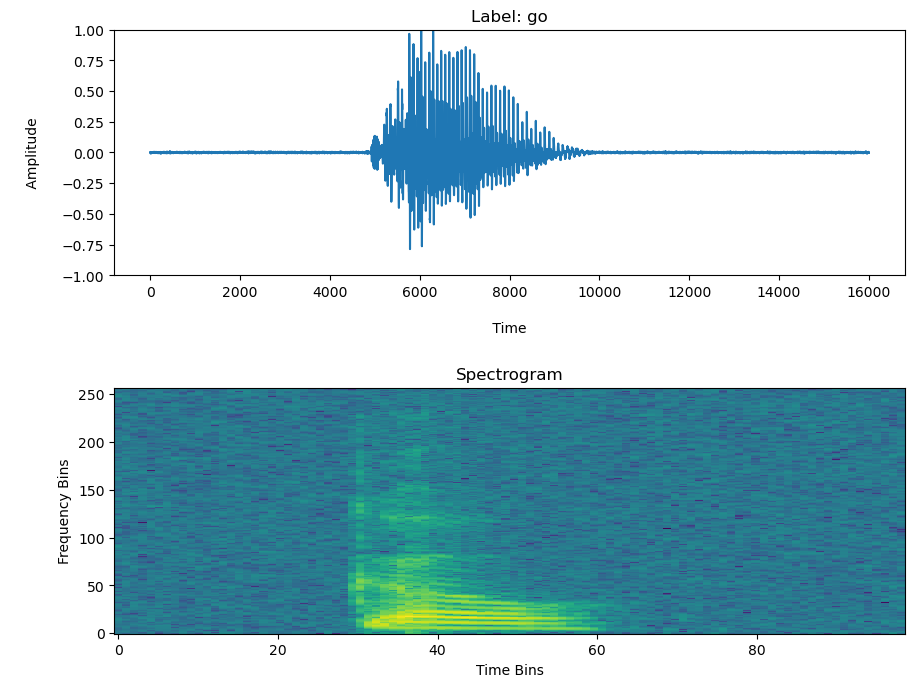

In [22]:
spect = get_spectrogram(audio_batch[5], label_batch[5], 
                            frame_length = 400, frame_step = 160, 
                            filt_noise = False, filt_thresh = 50,
                            add_noise = True, add_noise_thresh = 1e2,
                            norm_audio = False,
                            plot = True)

TensorShape([98, 40])

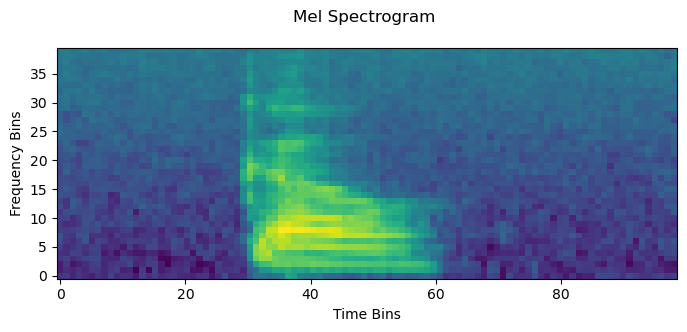

In [23]:
num_mel_bins = 40

lower_edge_hertz = 20 #Lower limit of human hearing
upper_edge_hertz = sample_rate // 2 #Nyquist frequency

num_mfccs = 13

log_mel_spect = conv_to_mel(spect,
                                num_mel_bins,
                                lower_edge_hertz,
                                upper_edge_hertz,
                                get_mfccs = False,
                                num_mfccs = num_mfccs,
                                plot = True)

log_mel_spect.shape

#### Calculating all MFCC coefficients (Energy, Delta, Delta-Delta)

Here, we calculate the remaining MFCC coefficientts: Energy, Delta and Delta-Delta.

To get delta values (and delta-delta values), we have two approaches:
- With Padding: We pad the matrix, and calculate the delta values for each frame, resulting in the same number of delta values as the number of frames.  However, this proves to be a wrong approach, since the zero padding can result in providing the model with incorrect data, hindering its progress.  
- Without Padding: We don't pad the matrix, resulting in a smaller number of delta values as opposed to the number of frames.  This will result in a smaller matrix, but the information will remain reliable, which is what has proven to be best for the model.

In [19]:
# Padding a tensor along axis = 0
# Done to account for edge cases while applying delta function
def pad_tensor(tensor, N, shape_factor):

    shape = np.array(tensor.shape)
    shape = shape[shape != None]

    repeat_counts = [N+1] + [1 for i in range(shape[0]-2)] + [N+1]
    tensor_padded = tf.repeat(tensor, repeats = repeat_counts, axis = 0 + shape_factor)
    
    return(tensor_padded)


# Applying the local derivative to padded tensor
def delta_function(tensor_padded, N, shape_factor):

    #Accounting for parallelizability case (where shape = (None, dim1, dim2))
    shape = np.array(tensor_padded.shape)
    shape = shape[shape != None]

    #Defining delta
    delta = None
    
    #Defining denominator
    delta_denom = (1/3)*N*(N+1)*(2*N+1)

    #Accounting for the padding, we construct the delta 
    for mfcc_pos in range(N, shape[0] - N):

        #Gets tensor slices to the right and left of the current position
        right_slice = tf.gather(tensor_padded, indices = range(mfcc_pos + 1, mfcc_pos + N + 1), axis = 0 + shape_factor)
        left_slice = tf.gather(tensor_padded, indices = range(mfcc_pos - N, mfcc_pos), axis = 0 + shape_factor)

        #Sums over the tensor slices
        right_sum = tf.math.reduce_sum(right_slice, axis = 0 + shape_factor)
        left_sum = tf.math.reduce_sum(left_slice, axis = 0 + shape_factor)

        #Gets the difference between the right and left slice sums
        diff = tf.expand_dims(right_sum - left_sum, axis = 0 + shape_factor)

        if delta is None: delta = diff / delta_denom
        else: delta = tf.concat([delta, diff / delta_denom], axis = 0 + shape_factor)
        
    return(delta)

In [20]:
#Calculating remaining coefficients (Energy, delta, delta-delta) and concatenating
# Argument N refers to the number of frames (mfccs) considered when calculating the delta
def mfcc_complete(mfccs, N = 2):

    if mfccs.shape[0] is None: shape_factor = 1
    else: shape_factor = 0

    #Calculating delta coefficients
    #Padding to account for edge cases when using delta function
    mfccs_padded = pad_tensor(mfccs, N, shape_factor)
    #print(f'Previous shape: {mfccs.shape}\nShape after padding: {mfccs_padded.shape}\n')
    
    delta = delta_function(mfccs_padded, N, shape_factor)
    #print('Shape of delta coefficients: ', delta.shape)

    #Calculating delta-delta coefficients
    delta_padded = pad_tensor(delta, N, shape_factor)
    delta_delta = delta_function(delta_padded, N, shape_factor)
    #print('Shape of delta_delta coefficients: ', delta_delta.shape)

    #Calculating energy coefficient for mfcc
    mfcc_energy = tf.math.reduce_sum(tf.square(mfccs), axis = 1 + shape_factor)
    mfcc_energy = tf.expand_dims(mfcc_energy, axis = 1 + shape_factor)
    #print('\nShape of Energy (MFCC): ', mfcc_energy.shape)

    #Calculating energy coefficient for delta
    mfcc_energy_padded = pad_tensor(mfcc_energy, N, shape_factor)
    delta_energy = delta_function(mfcc_energy_padded, N, shape_factor)
    #print('Shape of Energy (Delta): ', delta_energy.shape)

    #Calculating energy coefficient for delta-delta
    delta_energy_padded = pad_tensor(delta_energy, N, shape_factor)
    delta_delta_energy = delta_function(delta_energy_padded, N, shape_factor)
    #print('Shape of Energy (Delta-Delta): ', delta_energy.shape)

    #Concatenating all the coefficients per time frame
    mfccs_concat = tf.concat([mfccs, delta, delta_delta, mfcc_energy, delta_energy, delta_delta_energy], axis = 1 + shape_factor)
    #print('\nFinal shape of MFCC matrix: ', mfccs_concat.shape)

    return(mfccs_concat)

In [ ]:
mfccs_concat = mfcc_complete(log_mel_spect, N = 2)
mfccs_concat.shape

#### Stacking MFCCs

We stack the previous and further frames below and above the current frame.  This is done to add context to the current frame, and is mostly used for DNNs.  However, we find that stacking severly increases the number of parameters, and is not optimal for lightweight models, especially for DNNs which already have a large number of parameters.  

In [21]:
def mfccs_stack(frames, stack_left, stack_right, stack_padding = True):

    #Accounting for the parallelizing case when shape is (None, dim1, dim2)
    if frames.shape[0] is None: shape_factor = 1
    else: shape_factor = 0

    if stack_padding:
        #Padding the frames (along time) to make stacking easier
        repeat_list = [stack_left + 1] + [1 for i in range(frames.shape[0 + shape_factor] - 2)] + [stack_right + 1]
        frames_padded = tf.repeat(frames, repeats = repeat_list, axis = 0 + shape_factor)
    else:
        #If no padding, then we ignore the first few frames and the final few frames and stack on the rest of the frames
        #This results in the time dimension reducing, but with more reliable stackings, as we are not adding in aritifical pads
        frames_padded = frames
        frames = tf.gather(frames, indices = range(stack_left, frames.shape[0 + shape_factor] - stack_right), axis = 0 + shape_factor)
    
    # print('og shape: ', frames.shape)
    # print('padded shape: ', frames_padded.shape)

    #Defining a function to get slices from padded tensor
    frames_padded_slice = lambda pos: tf.gather(frames_padded, indices = range(pos, frames.shape[0 + shape_factor] + pos), axis = 0 + shape_factor)

    #Concatenating padded slices to original tensor from left and right
    frames_stack = frames
    for pos_left in range(stack_left): frames_stack = tf.concat([frames_padded_slice(pos_left), frames_stack], axis = 1 + shape_factor)
    #print('shape after left: ', frames_stack.shape)
    for pos_right in range(stack_right): frames_stack = tf.concat([frames_stack, frames_padded_slice(pos_right + stack_left + 1)], axis = 1 + shape_factor)
    # print('shape after right: ', frames_stack.shape)

    return(frames_stack)

In [ ]:
frames_stack = mfccs_stack(mfccs_concat, stack_left = 1, stack_right = 2, stack_padding = False)

---------

#### Smoothening Spectrogram using Filters and Convolutions

Due to noise (as part of data or white noise), the spectrograms can be confusing for the model to learn, as there is a possibility that it might overfit on the noise and fail to focus on the signal region.  To avoid this, we apply smoothening filters to equip the model with reliable and easy to learn spectrograms.  We consider two approaches:
- Gaussian Smoothing:  We apply a simple gaussian filter, of size (2, 2) and deviation 1.  This small size is to ensure that not too much information is lost, while making sure that the rough patches are being smoothed out.

- Sobel Sharpening:  We posit that the model can learn better if the edges of the image are clearly defined.  We do this by apply Sobel filters along the x and y axis separately, and adding up the results.  This provides edges that impose outwards, while the background remains uniform.  We also apply gaussian smoothing before and after the Sobel operation to ensure the noisy edges are not highlighted.

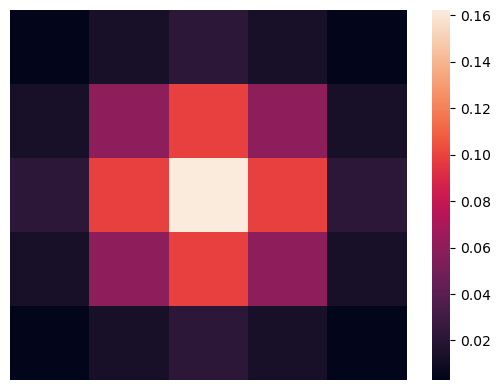

In [30]:
def get_gaussian_filter(size, sigma):
    
    half_size = size//2
    x_vals, y_vals = np.arange(-half_size, half_size+1), np.arange(-half_size, half_size+1)
    x_grid, y_grid = np.meshgrid(x_vals, y_vals)

    kernel = np.exp(-(x_grid**2 + y_grid**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)

    return(kernel)

def get_sobel_filter(direction = 'y'):

    if direction == 'y':
        return np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    if direction == 'x':
        return np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])


sns.heatmap(get_gaussian_filter(size = 5, sigma = 1))
plt.tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)

In [31]:
def tf_convolve(image, kernel, strides, padding = 'SAME'):
    
    #Convert image to shape (1, inp_height, inp_width, 1)
    image = tf.expand_dims(image, axis = 0)
    image = tf.expand_dims(image, axis = -1)

    #Convert kernel to shape (height, width, 1, 1)    
    kernel = tf.constant(kernel, dtype = float)
    kernel = tf.expand_dims(kernel, axis = -1)
    kernel = tf.expand_dims(kernel, axis = -1)

    #Convolution
    result = tf.nn.conv2d(image, kernel, [1, strides[0], strides[1], 1], padding)

    result = tf.squeeze(result, axis = 0)
    result = tf.squeeze(result, axis = -1)

    return result

In [32]:
def convolve_spect(log_mel_spect, 
                    gauss_size = 3, gauss_sigma = 1, 
                    apply_sobel = True,
                    padding = 'VALID'):

    #First Convolution (Smoothing): Gaussian
    gauss_kernel = get_gaussian_filter(size = gauss_size, sigma = gauss_sigma)

    spect_gauss = tf_convolve(image = log_mel_spect, 
                                        kernel = gauss_kernel,
                                        strides = (1, 1), 
                                        padding = padding)
    
    if apply_sobel:

    
        #Second Convolution (Frequency Distinction): Sobel x + Sobel y
        sobel_kernel = get_sobel_filter(direction = 'x')
        spect_sobel_x = tf_convolve(image = spect_gauss, 
                                            kernel = sobel_kernel, 
                                            strides = (1, 1), 
                                            padding = padding)

        sobel_kernel = get_sobel_filter(direction = 'y')
        spect_sobel_y = tf_convolve(image = spect_gauss, 
                                            kernel = sobel_kernel, 
                                            strides = (1, 1), 
                                            padding = padding)
        
        spect_sobel = spect_sobel_x + spect_sobel_y


        #Third Convolution (Smoothing): Gaussian
        gauss_kernel_2 = get_gaussian_filter(size = gauss_size, sigma = gauss_sigma)

        spect_gauss_2 = tf_convolve(image = spect_sobel, 
                                            kernel = gauss_kernel_2,
                                            strides = (1, 1), 
                                            padding = padding)
        
        return(spect_gauss_2)
    
    return(spect_gauss)


In [ ]:
spect_conv = convolve_spect(log_mel_spect,
                                gauss_size = 3,gauss_sigma = 1,
                                apply_sobel=True,
                                padding = 'VALID')


fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
fig.tight_layout(pad = 5)

plot_spect(log_mel_spect, ax = ax[0])
plot_spect(spect_conv, ax = ax[1], title = 'Spectrogram Convolved (Gaussian + Sobel)')
print(spect_conv.shape)

#### Converting datasets to mel spectrogram datasets

This is a master function or pipeline that implements all the above operations, pre-processing the data to our preffered settings, and making it ready for the model to train on.

In [151]:
def map_audio_to_spect(data, 
                        frame_length, frame_step, 
                        filt_noise, filt_thresh,
                        add_noise, add_noise_thresh,
                        num_mel_bins, lower_edge_hertz, upper_edge_hertz, 
                        gauss_size, gauss_sigma, apply_sobel, padding,
                        get_mfccs, num_mfccs, 
                        get_mfccs_delta, delta_padding,
                        stack_left, stack_right, stack_padding):

        #Get Spectrogram
        spect = lambda audio: get_spectrogram(audio, None, 
                                    frame_length, frame_step, 
                                    filt_noise, filt_thresh,
                                    add_noise, add_noise_thresh)

        #Convert to either log mel spect or mfccs
        log_mel_spect = lambda spect: conv_to_mel(spect, num_mel_bins, 
                                            lower_edge_hertz, upper_edge_hertz, 
                                            get_mfccs, num_mfccs)

        #If we want to process MFCCs (instead of spectrograms)
        if get_mfccs:
            if get_mfccs_delta:     #Adds in delta features
                final_result = lambda log_mel_spect: mfccs_stack(mfcc_complete(log_mel_spect, N = delta_padding), 
                                                    stack_left, stack_right, stack_padding)[..., tf.newaxis]
            else:   #No delta Features
                final_result = lambda log_mel_spect: mfccs_stack(log_mel_spect, stack_left, stack_right, stack_padding)[..., tf.newaxis]
        
        #Processing spectrograms
        else:   #Convolve spect applying either gaussian or sobel filters
            final_result = lambda log_mel_spect: convolve_spect(log_mel_spect, gauss_size, gauss_sigma, apply_sobel, padding)[..., tf.newaxis]
        
        #Map parallely
        return data.map(map_func = lambda audio, label : (final_result(log_mel_spect(spect(audio))), label), 
                            num_parallel_calls = tf.data.AUTOTUNE)


In [152]:
frame_length_time, frame_step_time = 25, 10 #In milli-seconds

frame_length = int(0.001 * sample_rate * frame_length_time)
frame_step = int(0.001 * sample_rate * frame_step_time)
filt_noise, filt_thresh = False, 50
add_noise, add_noise_thresh = True, 1e2

num_mel_bins = 40                       
lower_edge_hertz = 20                   #Lower limit of human hearing
upper_edge_hertz = sample_rate // 2     #Nyquist Frequency
gauss_size, gauss_sigma, apply_sobel, padding = 2, 1, False, 'VALID'

get_mfccs, num_mfccs = False, 13
get_mfccs_delta = False
delta_padding = 2     #Number of frames (mfccs) to consider when calculating the delta
stack_left, stack_right, stack_padding = 0, 0, False     #Frames to stack on left and right, Whether to apply frame padding or not

print(f'Frame Length (in samples): {frame_length}, Frame Stride (in samples): {frame_step}')

get_spect_ds = lambda data: map_audio_to_spect(data, 
                                                    frame_length, frame_step, 
                                                    filt_noise, filt_thresh,                                                    
                                                    add_noise, add_noise_thresh,
                                                    num_mel_bins, lower_edge_hertz, upper_edge_hertz,
                                                    gauss_size, gauss_sigma, apply_sobel, padding,
                                                    get_mfccs, num_mfccs, 
                                                    get_mfccs_delta, delta_padding,
                                                    stack_left, stack_right, stack_padding)

train_spect_ds = get_spect_ds(train_data)
val_spect_ds = get_spect_ds(val_data)
test_spect_ds = get_spect_ds(test_data)

Frame Length (in samples): 400, Frame Stride (in samples): 160


In [149]:
valid_data = val_spect_ds.map(lambda audio, label: audio)
valid_labels = val_spect_ds.map(lambda audio, label: label)

val_labels_arr = np.concatenate(np.array([batch_labels for batch_labels in valid_labels]), axis =  0)
val_labels_arr.shape

(2368, 8)

In [150]:
get_shapes(train_spect_ds)

Number of Training Batches: 300
Shape of audio data in batch: (64, 98, 12, 1)
Shape of labels in batch: (64, 8)


In [ ]:
get_shapes(val_spect_ds)

In [ ]:
get_shapes(test_spect_ds)

#### Plot the new datasets

Plots a 3x3 matrix made of spectrograms, each row corresponding to a label and each column corresponding to a sample.  This allows us to get a peek at how the transformed data is like, for each of the classes.

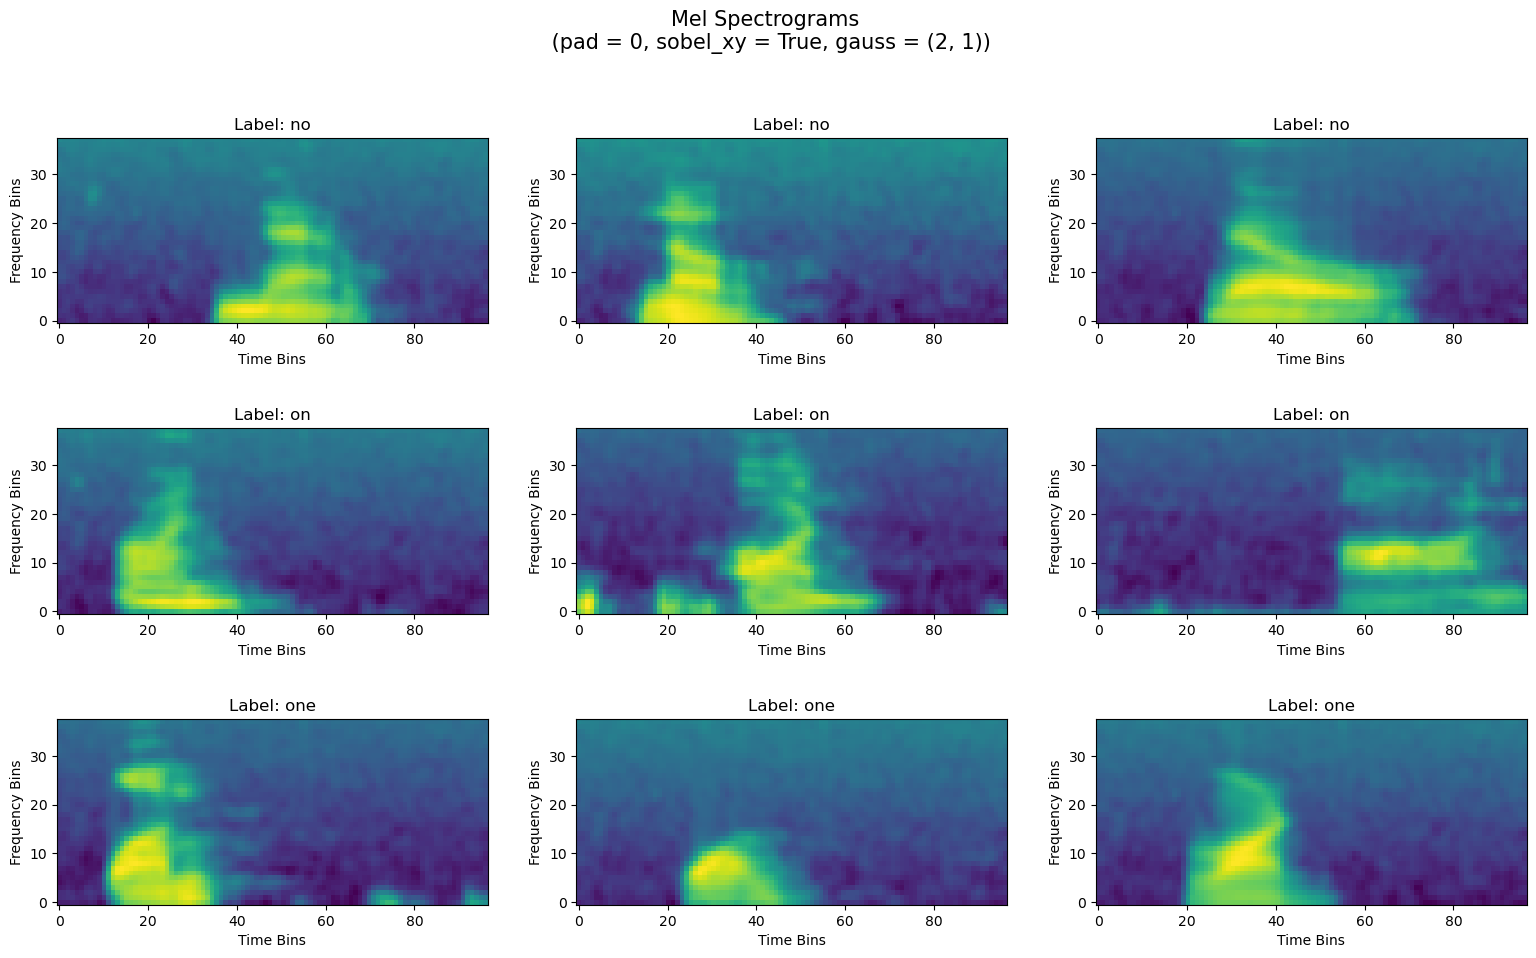

In [34]:
#Select labels for plotting, number of plots for each label
#plot_labels = ['yes', 'stop', 'left']
plot_labels = ['no', 'on', 'one']
plot_num = 3

#Obtain positions for selected labels
plot_labels_pos = [np.where(labels == elem)[0][0] for elem in plot_labels]

#Function for obtaining label counts in a batch
def get_labels_counts(label_list, ref_labels):
    uniqs, counts = np.unique(label_list, return_counts = True)

    uniqs_pos = [np.where(uniqs == l)[0][0] for l in ref_labels]
    ref_labels_counts = counts[uniqs_pos]
    return(ref_labels_counts)

batch = 0
for sample_spect, sample_label in train_spect_ds:

    batch += 1

    #Decode one hot encoding
    sample_label_decoded = decode_one_hot(sample_label)

    #Check if the ref labels are in the sample_label batch, if not, continue to the next batch
    check_presence = [ref_label in sample_label_decoded for ref_label in plot_labels_pos]
    if sum(check_presence) < 3: continue

    #Get ref label counts in the batch
    plot_labels_counts = get_labels_counts(sample_label_decoded, plot_labels_pos)
    if min(plot_labels_counts) >= plot_num: break

#print(plot_labels_counts)

#Obtain plot matrix positions
plot_labels_matrix = np.array([np.where(sample_label_decoded == l)[0][:plot_num] for l in plot_labels_pos])
#print(plot_labels_matrix)

#Plotting
fig, ax = plt.subplots(nrows = len(plot_labels), ncols = plot_num, figsize = (16, 10))

for i in range(len(plot_labels)):
    for j in range(plot_num):
        plot_spect(sample_spect[plot_labels_matrix[i, j]],
                    title = f'Label: {labels[sample_label_decoded[plot_labels_matrix[i, j]]]}',
                    ax = ax[i, j])

fig.suptitle('Mel Spectrograms \n (pad = 0, sobel_xy = True, gauss = (2, 1))', fontsize = 15)
fig.tight_layout(pad = 3)

## Building Model

In [38]:
#Using cache and prefetch to speed up reading data

train_spect_ds = train_spect_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spect_ds = val_spect_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spect_ds = test_spect_ds.cache().prefetch(tf.data.AUTOTUNE)

In [64]:
input_shape = get_shapes(train_spect_ds, return_shape = True)[1:]
print('\nInput Shape: ', input_shape)

n_labels = len(labels)
print('Number of labels: ', n_labels)

Number of Training Batches: 300
Shape of audio data in batch: (64, 96, 38, 1)
Shape of labels in batch: (64, 8)

Input Shape:  (96, 38, 1)
Number of labels:  8


#### Creating Non-Linear LoRA Layer

This is inspired from the LoRA adaptation common throughout NLP, and we posit that using this layer and giving it a non-linear activation, will help reduce the parameters while giving better performance.  We intend to replace dense layers (of size n) with a Non-linear LoRA layer (of size m > n) with the rank close to size n, allowing the model to utilize more nodes but update in a lower rank.  

In [37]:
class LoRA_Layer(layers.Layer):
    def __init__(self, units, rank, activation = None):
        super().__init__(name = 'LoRA_Layer', trainable = True)
        self.units = units
        self.rank = rank
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):

        self.matrix_A = self.add_weight(
                            shape = (input_shape[-1], self.rank),
                            trainable = True,
                            name = 'weights_matrix_A'
        )

        self.matrix_B = self.add_weight(
                            shape = (self.rank, self.units),
                            trainable = True,
                            name = 'weight_matrix_B'
        )

        self.bias = self.add_weight(
                        shape = (self.units,),
                        initializer = 'zeros',
                        trainable = True,
                        name = 'bias'
        )

    def call(self, input):
        output = tf.matmul(tf.matmul(input, self.matrix_A), self.matrix_B) + self.bias
        if self.activation: output = self.activation(output)
        return output

#### CNN

- cnn_mfcc_39 (55k params):  Takes in MFCC data, with delta, delta-delta and energy features included.

- cnn_mfcc_12 (35k params): Takes in MFCC data, without any additional features (delta, delta-delta, energy).

- cnn_spect_64 (32k params): Takes in Log Mel Spectrogram.

- cnn_spect_128 (78k params): Takes in Log Mel Spectrogram.

In [33]:
input_shape

TensorShape([96, 38, 1])

In [ ]:
cnn_mfcc_39 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 128, kernel_size = (30, 10), strides = (5, 2), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.MaxPooling2D(pool_size = (3, 2), strides = (3, 2)),

    layers.Conv2D(filters = 16, kernel_size = (1, 3), strides = (1, 1), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(rate = 0.25),

    layers.Flatten(),   
    
    #Non-Linear Low-Rank Layer
    #Linear_LoRA(units = 128, rank = 64),    
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(rate = 0.25),

    layers.Dense(n_labels, activation = 'softmax')
])

cnn_mfcc_39.summary()

In [28]:
cnn_mfcc_12 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 128, kernel_size = (29, 4), strides = (5, 1), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.MaxPooling2D(pool_size = (3, 1), strides = (3, 1)),

    layers.Conv2D(filters = 16, kernel_size = (1, 3), strides = (1, 1), kernel_regularizer=regularizers.L2(l2 = 0.01)),

    layers.Dropout(rate = 0.25),

    layers.Flatten(),   
    
    #Non-Linear Low-Rank Layer
    #LoRA_Layer(units = 64, rank = 32, activation = 'relu'),    
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(rate = 0.25),

    layers.Dense(n_labels, activation = 'softmax')
])

cnn_mfcc_12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 9, 128)        14976     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 9, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 7, 16)          6160      
                                                                 
 dropout (Dropout)           (None, 4, 7, 16)          0         
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 32)                14368     
                                                        

In [ ]:
cnn_spect_128 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 128, kernel_size = (25, 10), strides = (5, 2), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.MaxPooling2D(pool_size = (3, 2), strides = (3, 2)),

    layers.Conv2D(filters = 16, kernel_size = (1, 3), strides = (1, 1), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(rate = 0.25),

    layers.Flatten(),   
    
    #Linear Low-Rank Layer
    #Linear_LoRA(units = 128, rank = 64),    
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(rate = 0.25),

    layers.Dense(n_labels, activation = 'softmax')
])

cnn_spect_128.summary()

In [65]:
cnn_spect_64 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 64, kernel_size = (25, 10), strides = (5, 2), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.MaxPooling2D(pool_size = (3, 2), strides = (3, 2)),

    layers.Conv2D(filters = 16, kernel_size = (1, 3), strides = (1, 1), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(rate = 0.25),

    layers.Flatten(),   
    
    #Non-Linear Low-Rank Layer
    #LoRA_Layer(units = 64, rank = 32, activation = 'relu'),    
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(rate = 0.25),

    layers.Dense(n_labels, activation = 'softmax')
])

cnn_spect_64.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 15, 15, 64)        16064     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 16)          3088      
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 16)          0         
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                12832     
                                                      

In [117]:
cnn_spect_64.load_weights('./best_weights')

#### DNN

In [ ]:
dnn_3x128 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Flatten(),

    layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.25),

    layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.25),

    layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.25),

    layers.Dense(n_labels, activation = 'softmax')
])

dnn_3x128.summary()

In [ ]:
dnn_3xs = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Flatten(),

    layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.25),

    layers.Dense(32, activation = 'relu', kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.25),

    layers.Dense(16, activation = 'relu', kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.25),

    layers.Dense(n_labels, activation = 'softmax')
])

dnn_3xs.summary()

## Training Model

#### Training

In [66]:
#Compiling model
model = cnn_spect_64
model_name = 'cnn_spect_64'

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['categorical_accuracy', tf.keras.metrics.AUC(multi_label = True, num_labels = len(labels))],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 15, 15, 64)        16064     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 16)          3088      
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 16)          0         
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                12832     
                                                      

In [41]:
#Settings callback to log validation results, which will be used to calculate precision, recall, f1 scores for each class
class val_pred_hist(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        
        if not logs:
            logs = {'val_preds': self.model.predict(valid_data)}

        elif 'val_preds' not in logs.keys():
            logs['val_preds'] = self.model.predict(valid_data)

        else:
            logs['val_preds'].append(self.model.predict(valid_data))

In [42]:
EPOCHS = 50

history = model.fit(
    train_spect_ds,
    validation_data=val_spect_ds,
    epochs=EPOCHS,
    shuffle = True,                     #Shuffles the data
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy', 
                                                mode='max', 
                                                min_delta = 0.01,
                                                patience = 10,
                                                verbose=1),
                val_pred_hist()]
)

Epoch 1/50
300/300 [==============================] - 39s 125ms/step - loss: 1.7359 - categorical_accuracy: 0.4357 - auc: 0.8173 - val_loss: 1.1228 - val_categorical_accuracy: 0.6643 - val_auc: 0.9454 - val_preds: 0.1250
Epoch 2/50
300/300 [==============================] - 6s 20ms/step - loss: 1.0288 - categorical_accuracy: 0.6882 - auc: 0.9421 - val_loss: 0.7457 - val_categorical_accuracy: 0.8150 - val_auc: 0.9752 - val_preds: 0.1250
Epoch 3/50
300/300 [==============================] - 6s 19ms/step - loss: 0.8458 - categorical_accuracy: 0.7499 - auc: 0.9607 - val_loss: 0.6619 - val_categorical_accuracy: 0.8307 - val_auc: 0.9801 - val_preds: 0.1250
Epoch 4/50
300/300 [==============================] - 5s 18ms/step - loss: 0.7599 - categorical_accuracy: 0.7791 - auc: 0.9676 - val_loss: 0.5871 - val_categorical_accuracy: 0.8514 - val_auc: 0.9839 - val_preds: 0.1250
Epoch 5/50
300/300 [==============================] - 6s 19ms/step - loss: 0.7096 - categorical_accuracy: 0.7924 - auc: 0.

In [58]:
model.save_weights('./best_weights')

#### Metrics: Accuracy, Categorical Loss

In [42]:
#Saves the training and validation information
def save_run(history, model_name, dir_add = '', metrics = 0, metric_name = None, labels = None):

    if metrics == 0: 
        dir_metrics = fr'metrics0/metrics0_{model_name}{dir_add}.csv'
        df_history = pd.DataFrame(history.history)

    else: 
        parent_dir = fr'metrics1/{model_name}'
        dir_metrics = parent_dir + fr'/{metric_name}{dir_add}.csv'
        df_history = pd.DataFrame(history, columns = labels)

        #If directory does not exist, make one
        if not os.path.exists(parent_dir): os.makedirs(parent_dir)

    with open(dir_metrics, 'w') as f:
        df_history.to_csv(f)
    
    print(f'File Saved in {dir_metrics}')

In [43]:
metrics = history.history
metric_names = list(metrics.keys())
metric_names

['loss',
 'categorical_accuracy',
 'auc',
 'val_loss',
 'val_categorical_accuracy',
 'val_auc',
 'val_preds']

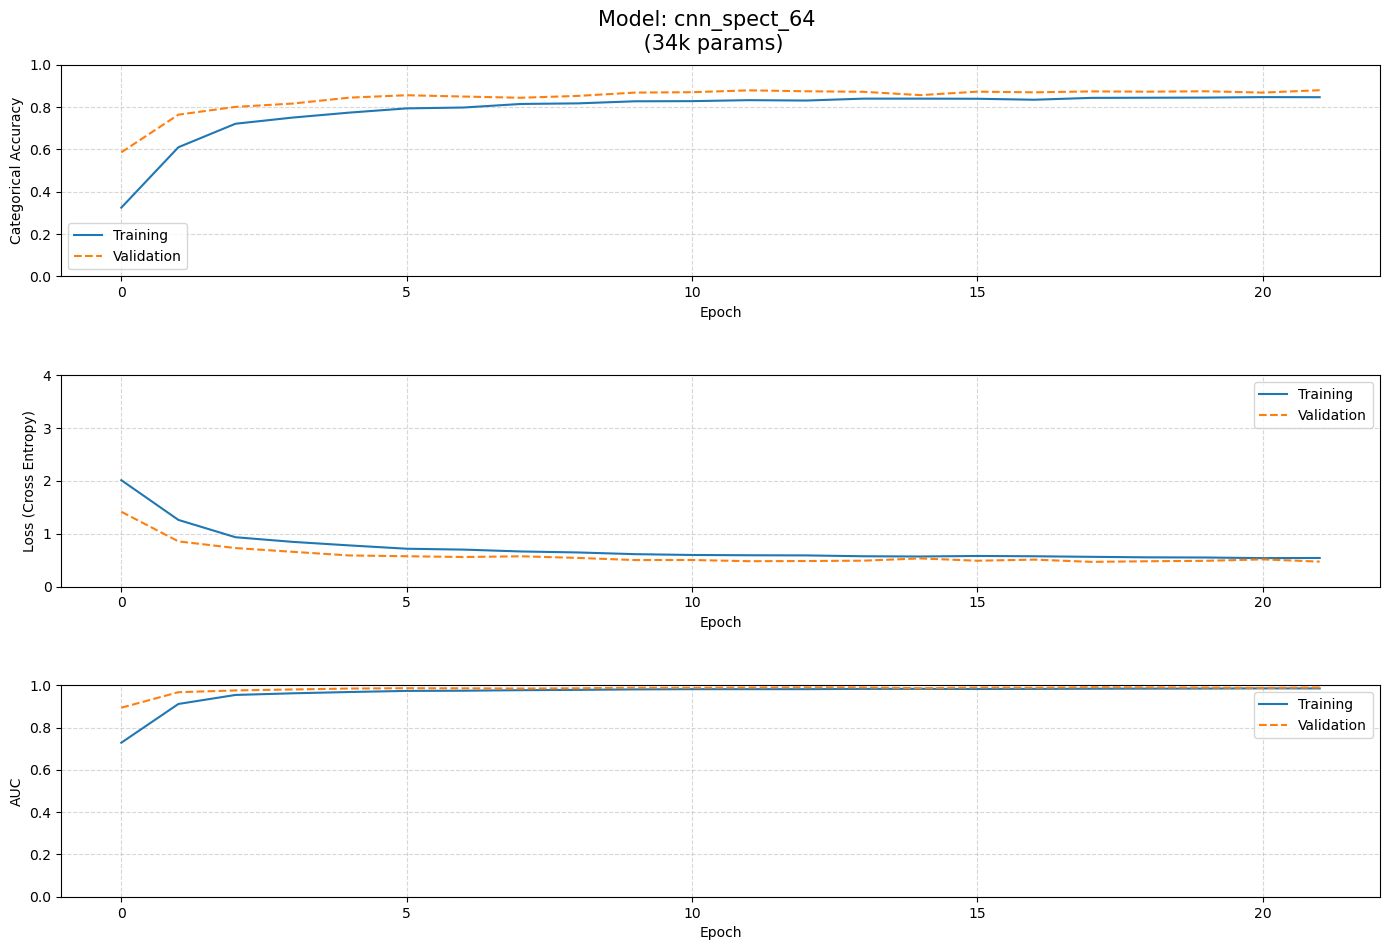

In [44]:
def plot_metric(ax, history, train, val, metric_label, ylim = (0, 1)):
    ax.plot(history.epoch, train)
    ax.plot(history.epoch, val, linestyle = '--')
    ax.legend(['Training', 'Validation'])
    ax.set(ylim = ylim, xlabel = 'Epoch', ylabel = metric_label)
    ax.grid(True, alpha = 0.5, linestyle = '--')


fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 10))
fig.tight_layout(pad = 5)
# fig.suptitle(f'Model: {model_name}', fontsize = 15)
fig.suptitle(f'Model: cnn_spect_64 \n (34k params)\n', fontsize = 15)

plot_metric(ax[0], history, metrics['categorical_accuracy'], metrics['val_categorical_accuracy'], metric_label = 'Categorical Accuracy')
plot_metric(ax[1], history, metrics['loss'], metrics['val_loss'], metric_label = 'Loss (Cross Entropy)', ylim = (0, 4))
plot_metric(ax[2], history, metrics[metric_names[2]], metrics[metric_names[5]], metric_label = 'AUC')

In [ ]:
save_run(history, model_name = model_name, dir_add = '', metrics = 0)

#### Metrics: Precision, Recall, F1 per Label

In [45]:
def decode_batch_preds(pred_labels):

    #Convert predictions to one hot format (assigning 1 to the max and 0 to the rest)
    one_hot_max = lambda row: [1 if elem == np.max(row) else 0 for elem in row]
    pred_labels = np.apply_along_axis(one_hot_max, arr = pred_labels, axis = 1)

    #Decode the predictions
    pred_labels = decode_one_hot(pred_labels)
    return pred_labels

In [46]:
def get_metric_per_label(history, val_labels):

    #Convert validation labels from one hot to actual labels
    val_labels = decode_one_hot(val_labels)

    #Get model predictions per epoch
    val_preds_epoch = np.array(history.history['val_preds'])

    #Convert to one-hot and decode predictions
    n_epoch = val_preds_epoch.shape[0]
    val_preds_epoch = np.array([decode_batch_preds(val_preds_epoch[epoch]) for epoch in range(n_epoch)])

    #Obtain precision, recall and f1 scores
    precision_epoch, recall_epoch, f1_epoch = [], [], []

    for epoch in range(n_epoch):
        precision, recall, f1, _ = prf(val_labels, val_preds_epoch[epoch], labels = np.arange(8))

        precision_epoch.append(precision)
        recall_epoch.append(recall)
        f1_epoch.append(f1)
    
    return np.array(precision_epoch), np.array(recall_epoch), np.array(f1_epoch)

In [47]:
def plot_per_label(ax, metric_epoch, metric_name):

        #Get number of epochs
        epochs = np.arange(metric_epoch.shape[0])

        #Get the macro average
        macro_metric_epoch = np.mean(metric_epoch, axis = 1)

        #Plotting
        ax.plot(epochs, macro_metric_epoch, linestyle = '-', color = 'red', label = f'Macro-{metric_name}')
        ax.plot(epochs, metric_epoch, label = labels, alpha = 0.3, linestyle = '--')
        

        ax.set(ylim = (0, 1), 
                title = f'Validation {metric_name} \n',
                xlabel = '\n Epoch', 
                ylabel = f'{metric_name} \n')

        ax.grid(True, alpha = 0.5, linestyle = '--')
        ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), shadow = True)

In [48]:
#Get metric per label
precision_epoch, recall_epoch, f1_epoch = get_metric_per_label(history, val_labels_arr)

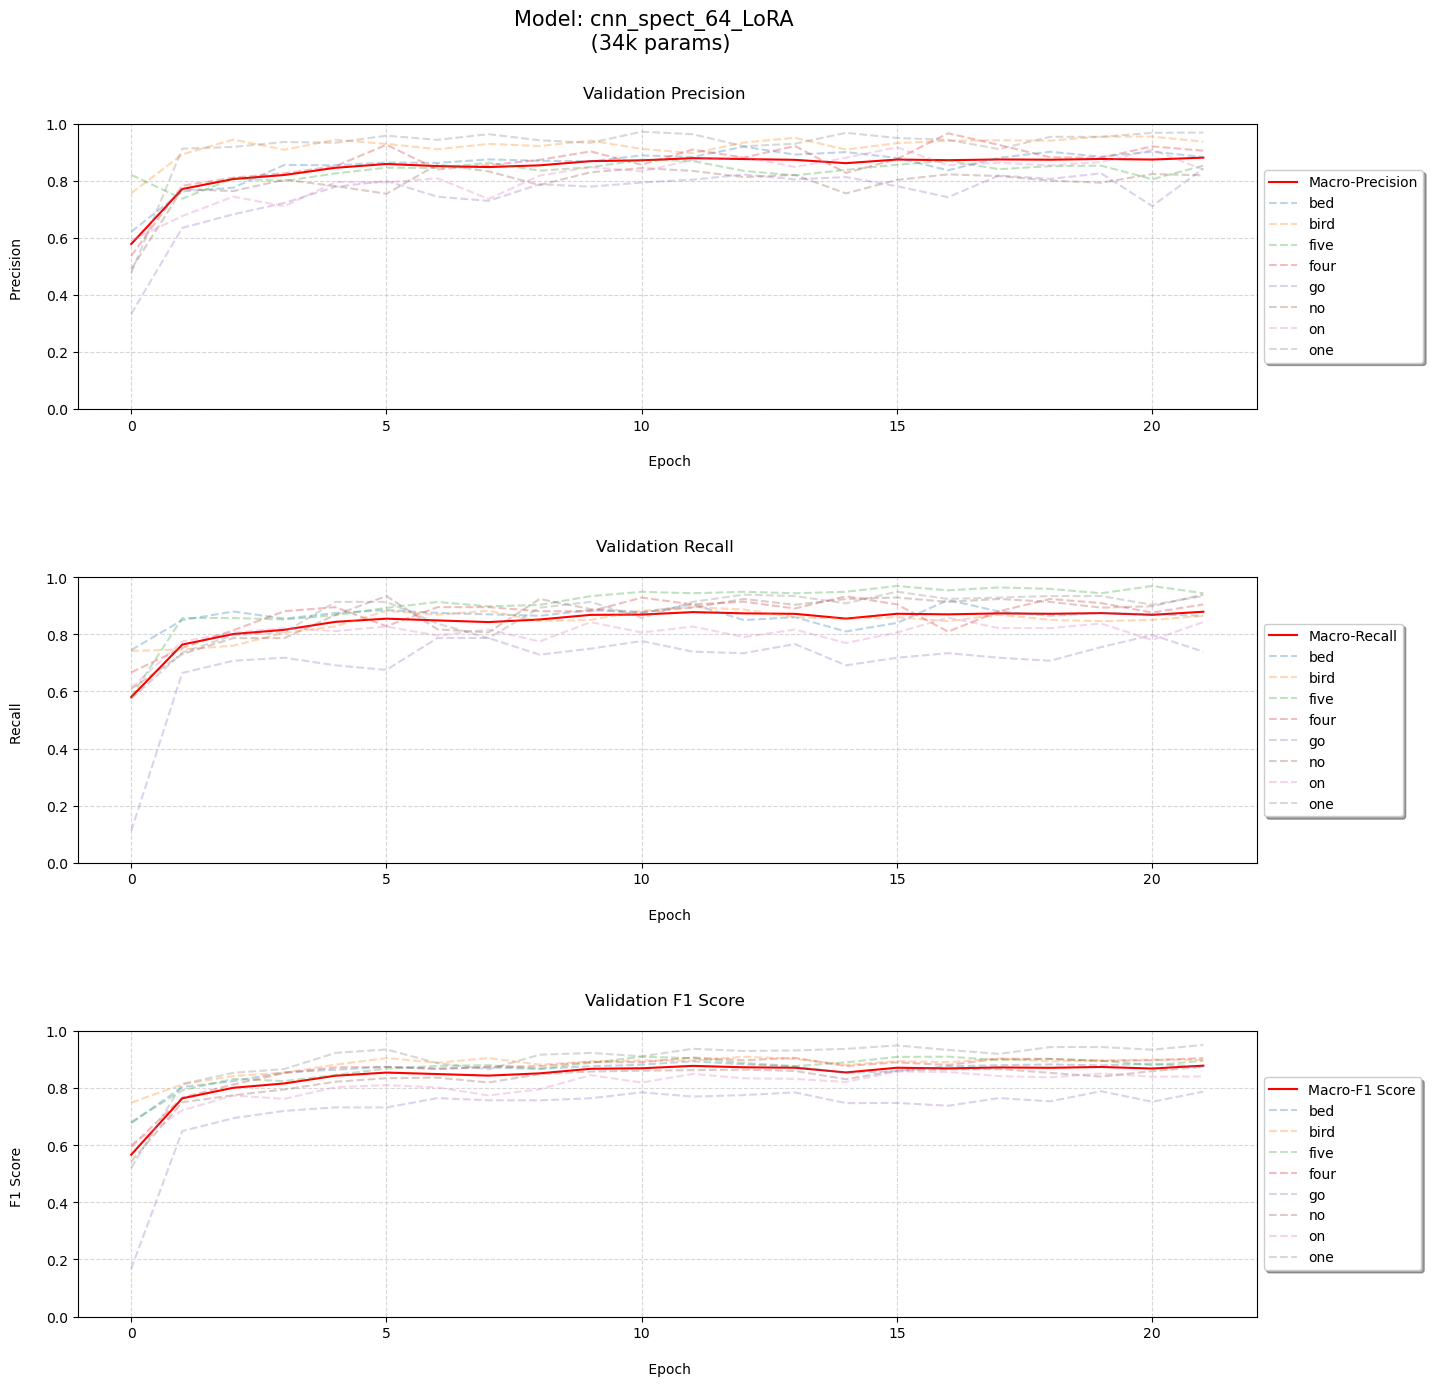

In [49]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 15))
fig.tight_layout(pad = 10)
#fig.suptitle(f'Model: {model_name}', fontsize = 15)
fig.suptitle(f'Model: cnn_spect_64_LoRA \n (34k params)\n', fontsize = 15)

plot_per_label(ax[0], precision_epoch, metric_name = 'Precision')
plot_per_label(ax[1], recall_epoch, metric_name = 'Recall')
plot_per_label(ax[2], f1_epoch, metric_name = 'F1 Score')

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))
fig.tight_layout(pad = 5)
fig.suptitle(f'Final Validation Scores for {model_name}', fontsize = 15)

ax[0].bar(labels, precision_epoch[-1])
ax[0].set(title = 'Precision', ylim = (0, 1))

ax[1].bar(labels, recall_epoch[-1])
ax[1].set(title = 'Recall', ylim = (0, 1))

ax[2].bar(labels, f1_epoch[-1])
ax[2].set(title = 'F1 Score', ylim = (0, 1))

In [ ]:
save_run(precision_epoch, model_name = model_name, dir_add = '', metrics = 1, metric_name = 'precision', labels = labels)
save_run(recall_epoch, model_name = model_name, dir_add = '', metrics = 1, metric_name = 'recall', labels = labels)
save_run(f1_epoch, model_name = model_name, dir_add = '', metrics = 1, metric_name = 'f1', labels = labels)

## Hyper-Parameter Grid Search

Grid Search for optimizing hyperparameters.

In [ ]:
input_shape = get_shapes(train_spect_ds, return_shape = True)[1:]
print('\nInput Shape: ', input_shape)

n_labels = len(labels)
print('Number of labels: ', n_labels)

def model_outline(s1_t, s1_f, LoRA):
    model = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 64, kernel_size = (25, 10), strides = (s1_t, s1_f), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.MaxPooling2D(pool_size = (3, 2), strides = (3, 2)),

    layers.Conv2D(filters = 16, kernel_size = (1, 3), strides = (1, 1), kernel_regularizer=regularizers.L2(l2 = 0.01)),
    layers.Dropout(rate = 0.25),

    layers.Flatten(),   
    ])

    if LoRA: model.add(LoRA_Layer(units = 32, rank = 16, activation = 'relu')),
    else: model.add(layers.Dense(32, activation = 'relu'))

    model.add(layers.Dropout(rate = 0.25))
    model.add(layers.Dense(n_labels, activation = 'softmax'))


    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['categorical_accuracy', tf.keras.metrics.AUC(multi_label = True, num_labels = len(labels))],
    )

    return(model)

model = model_outline(5, 2, True)
model.summary()

In [ ]:
def grid_search_model(hp):

    s1_t = hp.Choice('s1_t', [5, 7])
    s1_f = hp.Choice('s1_f', [2, 4])
    LoRA = hp.Choice('LoRA', [True, False])


    model = model_outline(s1_t, s1_f, LoRA)
    return model

grid_search_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.GridSearch(hypermodel = grid_search_model, 
                                    objective = 'val_categorical_accuracy',
                                    overwrite = True,
                                    directory = 'GS_cnn_cust_64_s1f_s1t_LoRA')
tuner.search_space_summary()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy', 
                                                mode='max', 
                                                min_delta = 0.01,
                                                patience = 5,
                                                verbose=0)

tuner.search(train_spect_ds, 
                epochs = 50,
                validation_data = val_spect_ds,
                callbacks = [early_stop])

In [ ]:
tuner.results_summary()

## Comparisons with ROC Curves

In [153]:
def get_preds(model, test_spect_ds, return_pred_raw = False, return_pred_1h = False):

    #Get predictions (as distributions for each data)
    pred_raw = model.predict(test_spect_ds)
    if return_pred_raw:
        print(f'Output Shape: {pred_raw.shape}')
        return(pred_raw)
    
    #Collapse to one hot vector
    one_hot_max = lambda row: [1 if elem == np.max(row) else 0 for elem in row]
    pred_1h = np.apply_along_axis(one_hot_max, arr = pred_raw, axis = 1)
    if return_pred_1h: 
        print(f'Output Shape: {pred_1h.shape}')
        return(pred_1h)

    #Get Labels from one hot
    pred_labels = decode_one_hot(pred_1h)
    print(f'Output Shape: {pred_labels.shape}')
    return(pred_labels)

pred_raw = get_preds(model, val_spect_ds, return_pred_raw = True)
pred_raw[0]

37/37 [==============================] - 2s 34ms/step
Output Shape: (2368, 8)


array([0.21114899, 0.20074013, 0.07380902, 0.09204084, 0.07055274,
       0.09820002, 0.10622023, 0.14728805], dtype=float32)

In [154]:
def get_true_labels(test_spect_ds, return_true_1h):

    #Gets true labels as one hot vectors
    true_labels = np.array(list(test_spect_ds.map(lambda spect, label: label)))
    true_labels = np.concatenate(true_labels, axis = 0)
    if return_true_1h:
        print(f'Output Shape: {true_labels.shape}')
        return(true_labels)
    
    #Decodes one hot to integer class labels
    true_labels = decode_one_hot(true_labels)
    print(f'Output Shape: {true_labels.shape}')
    return(true_labels)

true_1h = get_true_labels(val_spect_ds, return_true_1h = True)
true_1h[0]

Output Shape: (2368, 8)


array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [155]:
#Gets False and True positive rates to plot ROC curve, and saves the values
def get_roc_curve(true_1h, pred_raw, save_results = False, model = None):

    fpr, tpr, thresholds = {}, {}, {}

    #Gets fpr, tpr for each class
    for i in range(len(labels)):
        fpr[i], tpr[i], thresholds[i] = roc_curve(true_1h[:, i], pred_raw[:, i])

    #Collapses fpr and gets unique x axis values to plot roc curve in
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

    #Obtains mean values by interpolating on all_fpr using fpr, tpr for each class
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(labels)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(labels)
    fpr['macro'], tpr['macro'] = all_fpr, mean_tpr

    #Saves results in directory
    if save_results:
        df = pd.DataFrame([fpr_macro, tpr_macro]).transpose().rename(columns = {0: 'fpr', 1: 'tpr'})

        save_dir = fr'metrics2/{model}.csv'
        with open(save_dir, 'w') as f:
            df.to_csv(f)

        print(f'File saved in {save_dir}')

    #Returns only macro averages results
    return(fpr['macro'], tpr['macro'])

fpr_macro, tpr_macro = get_roc_curve(true_1h, pred_raw)

In [ ]:
fpr_macro, tpr_macro = get_roc_curve(true_1h, pred_raw, save_results = True, model = model_name)

##### Plotting ROC Curve

In [156]:
#Reading csv file

def roc_from_csv(file_name):

    df_dir = f'metrics2/{file_name}.csv'

    df = pd.read_csv(df_dir)
    fpr_macro, tpr_macro = df['fpr'], df['tpr']

    return(fpr_macro, tpr_macro)

#fpr_cnn_mfcc_12_LoRA, tpr_cnn_mfcc_12_LoRA = roc_from_csv(file_name = 'cnn_mfcc_12_LoRA')
#fpr_cnn_cust_64_LoRA, tpr_cnn_cust_64_LoRA = roc_from_csv(file_name = 'cnn_cust_64_LoRA')

fpr_gaussian, tpr_gaussian = roc_from_csv(file_name = 'cnn_cust_64_gaussian')
fpr_cnn_mfcc_12, tpr_cnn_mfcc_12 = roc_from_csv(file_name = 'cnn_mfcc_12')
fpr_cnn_mfcc_39, tpr_cnn_mfcc_39 = roc_from_csv(file_name = 'cnn_mfcc_39')


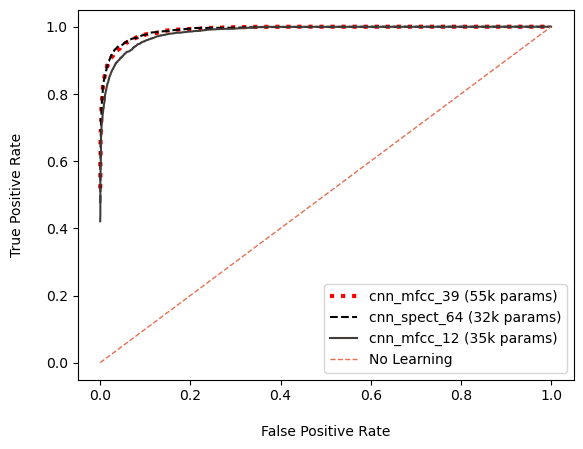

In [164]:
line_color1 = '#e76f51'
line_color2 = '#264653'
line_color3 = '#0081a7'
line_color4 = '#403d39'

plt.plot(fpr_cnn_mfcc_39, tpr_cnn_mfcc_39, label = 'cnn_mfcc_39 (55k params)', color = 'red', linestyle = 'dotted', linewidth = 3)
plt.plot(fpr_gaussian, tpr_gaussian, label = 'cnn_spect_64 (32k params)', color = 'black', linestyle = 'dashed')
#plt.plot(fpr_sobel, tpr_sobel, label = 'Sobel', color = line_color4, linestyle = 'dashed')
#plt.plot(fpr_cnn_mfcc_39, tpr_cnn_mfcc_39, label = 'cnn_mfcc_39 (55k params)', color = line_color3)
plt.plot(fpr_cnn_mfcc_12, tpr_cnn_mfcc_12, label = 'cnn_mfcc_12 (35k params)', color = line_color4)



plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle = 'dashed', linewidth = 1, color = line_color1, label = 'No Learning')
plt.xlabel('\nFalse Positive Rate')
plt.ylabel('True Positive Rate\n')
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0.9, 1)
plt.legend()

In [18]:
from sklearn.metrics import auc

print(auc(fpr_gaussian, tpr_gaussian))
print(auc(fpr_cnn_mfcc_12_LoRA, tpr_cnn_mfcc_12_LoRA))
print(auc(fpr_cnn_mfcc_12_LoRA, tpr_cnn_mfcc_12_LoRA))
print(auc(fpr_cnn_mfcc_12, tpr_cnn_mfcc_12))

0.9907532282161946
0.9886013477410266
0.9886013477410266
0.985154489898758


## Testing Model

In [118]:
model.evaluate(test_spect_ds, return_dict=True)

38/38 [==============================] - 2s 9ms/step - loss: 0.4379 - categorical_accuracy: 0.8853 - auc_1: 0.9899


{'loss': 0.4378654658794403,
 'categorical_accuracy': 0.8852795958518982,
 'auc_1': 0.9898514747619629}

Output Shape: (2432,)
38/38 [==============================] - 0s 3ms/step
Output Shape: (2432,)


[Text(0.5, 58.7222222222222, '\nPredicted'),
 Text(95.72222222222221, 0.5, 'Actual\n')]

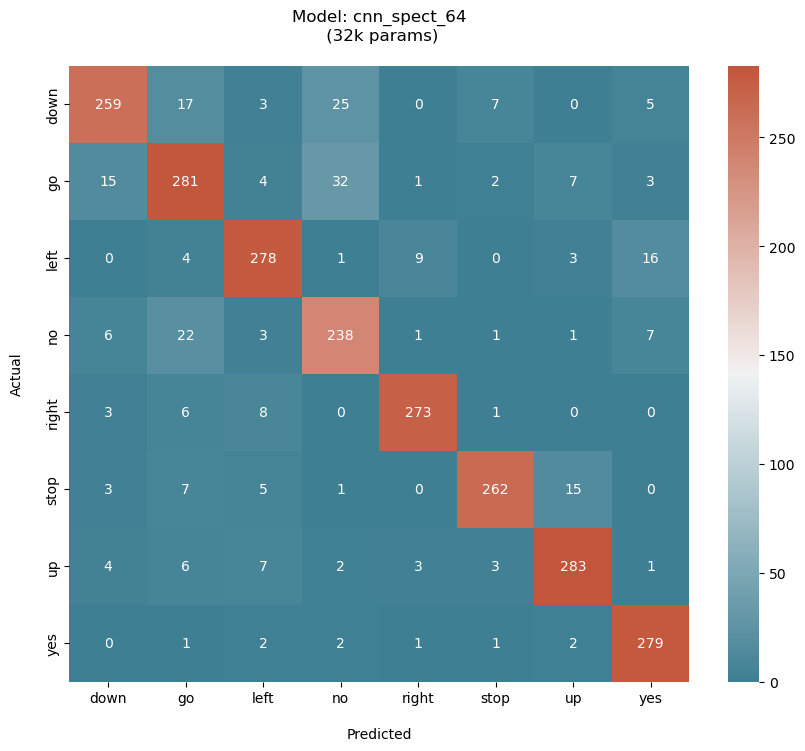

In [47]:
true_labels = get_true_labels(test_spect_ds, return_true_1h = None)
pred_labels = get_preds(model, test_spect_ds)

conf_mat = tf.math.confusion_matrix(true_labels, pred_labels)

#cmap = sns.light_palette("seagreen", as_cmap=True)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(conf_mat.numpy(),
                xticklabels = labels,
                yticklabels = labels,
                annot = True,
                cmap = cmap,
                fmt = 'g',
                ax = ax)

ax.set_title(f'Model: cnn_spect_64\n (32k params)\n', fontsize = 12)
ax.set(xlabel = '\nPredicted', ylabel = 'Actual\n')

#### Time, Memory Usage

In [124]:
def get_prediction(model, audio_data, audio_label, use_mfccs = False, plot_preds = False):

    #Get one hot encoding for correct label
    #label_pos = np.argwhere(labels == int(audio_label))[0][0]
    #label_pos = int(audio_label)
    #label_one_hot = encode(label_pos)
    label_one_hot = audio_label

    #Squeeze channel dimension
    #audio_tensor = tf.squeeze(audio_data, axis = -1)
    audio_tensor = audio_data

    #Get Spectrogram
    spect_rt = get_spectrogram(audio_tensor, label_one_hot, 
                                frame_length = 400, frame_step = 160,
                                filt_noise = False, filt_thresh = 50,
                                add_noise = True, add_noise_thresh = 1e2,                                                   
                                plot = False)
    

    #Get Log mel Spectrogram or MFCCs
    num_mel_bins = 40

    lower_edge_hertz = 20 #Lower limit of human hearing
    upper_edge_hertz = sample_rate // 2 #Nyquist frequency

    num_mfccs = 13
    stack_left, stack_right, stack_padding = 5, 5, False

    log_mel_spect_rt = conv_to_mel(spect_rt,
                                    num_mel_bins,
                                    lower_edge_hertz,
                                    upper_edge_hertz,
                                    get_mfccs = use_mfccs,
                                    num_mfccs = num_mfccs)
    
    if not use_mfccs: result = convolve_spect(log_mel_spect_rt, 
                                                gauss_size = 2, gauss_sigma = 1,
                                                apply_sobel = False, padding = 'VALID')[..., tf.newaxis]
    else: result = (log_mel_spect_rt)[..., tf.newaxis]

    result = (result)[tf.newaxis, ...]
    pred_rt = model(result)
    pred_rt = tf.nn.softmax(pred_rt)[0].numpy()

    pred_label = labels[np.argmax(pred_rt)]

    #Plot Predictions
    if plot_preds:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10.5, 5))

        ax.bar(labels, pred_rt)
        ax.set(title = f'Predictions\nCorrect Label: {correct_label}', xlabel = '\nLabel', ylabel = 'Probability\n')

    return(pred_label)   


In [125]:
label_batch[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

In [127]:
for audio_batch, label_batch in test_data: break

sample_id = 1
true_label = labels[np.argwhere(label_batch[sample_id] == 1)[0][0]]

pred = get_prediction(model, audio_label = label_batch[sample_id], audio_data = audio_batch[sample_id])
#print(f'\nPredicted Label: {pred} \nTrue Label: {labels[label_batch[0]]}')
print(f'\nPredicted Label: {pred} \nTrue Label: {true_label}')




Predicted Label: right 
True Label: right


In [137]:
start_time = time()

for batch_count, (audio_batch, audio_label) in enumerate(test_data):
    #print(audio_batch.shape, audio_label.shape)
    for audio, label in zip(audio_batch, audio_label):
        #print(audio.shape, label.shape)
        pred_label = get_prediction(model, audio_data = audio, audio_label = label)
        #print(pred_label, labels[label])

    if batch_count == 2: break

end_time = time()
inference_time = end_time - start_time

print(f'Average Inference Time: {(inference_time / ((batch_count+1) * 64)) * 1000} ms')

Average Inference Time: 39.94211430350939 ms


In [502]:
#Memory Measurement

tracemalloc.start()
start_snapshot = tracemalloc.take_snapshot()


for audio_batch, audio_label in test_data:
    #print(audio_batch.shape, audio_label.shape)
    for audio, label in zip(audio_batch, audio_label):
        #print(audio.shape, label.shape)
        pred_label = get_prediction(model, audio_data = audio, audio_label = label)
        #print(pred_label, labels[label])

    break


end_snapshot = tracemalloc.take_snapshot()

stats = end_snapshot.compare_to(start_snapshot, 'lineno')
for stat in stats[:10]:
    print(stat)

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")

c:\Users\Admin\anaconda3\envs\ML\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:849: size=8713 B (+8713 B), count=152 (+152), average=57 B
c:\Users\Admin\anaconda3\envs\ML\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:6012: size=4776 B (+4776 B), count=82 (+82), average=58 B
c:\Users\Admin\anaconda3\envs\ML\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:8537: size=4671 B (+4671 B), count=79 (+79), average=59 B
c:\Users\Admin\anaconda3\envs\ML\lib\site-packages\tensorflow\python\framework\constant_op.py:102: size=3752 B (+3752 B), count=67 (+67), average=56 B
c:\Users\Admin\anaconda3\envs\ML\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:1100: size=3533 B (+3533 B), count=61 (+61), average=58 B
c:\Users\Admin\anaconda3\envs\ML\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:1996: size=3310 B (+3310 B), count=55 (+55), average=60 B
c:\Users\Admin\anaconda3\envs\ML\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:9355: size=3246 B (+3246 B

## Real Time Prediction

In [138]:
def process_audio(audio_tensor):
    
    #If tensor shape is less than required sample size
    if audio_tensor.shape[0] < 16000:
        diff = 16000 - audio_tensor.shape[0]
        audio_tensor = tf.concat([audio_tensor, tf.zeros(diff)], axis = 0)

    #Normalizing tensor
    max_val = tf.math.reduce_max(audio_tensor)
    audio_tensor /= max_val

    return(audio_tensor)

In [139]:
def get_prediction(model, audio_data, audio_label, use_mfccs = False, plot_preds = False):

    #Get one hot encoding for correct label
    label_pos = np.argwhere(labels == audio_label)[0][0]
    label_one_hot = encode(label_pos)

    #Squeeze channel dimension
    audio_tensor = audio_data
    #audio_tensor = tf.squeeze(audio_data, axis = -1)

    #Get Spectrogram
    spect_rt = get_spectrogram(audio_tensor, label_one_hot, 
                                frame_length = 400, frame_step = 160,
                                filt_noise = False, filt_thresh = 50,
                                add_noise = True, add_noise_thresh = 1e2,                                                   
                                plot = plot_preds)
    

    #Get Log mel Spectrogram or MFCCs
    num_mel_bins = 40

    lower_edge_hertz = 20 #Lower limit of human hearing
    upper_edge_hertz = sample_rate // 2 #Nyquist frequency

    num_mfccs = 13
    stack_left, stack_right, stack_padding = 5, 5, False

    log_mel_spect_rt = conv_to_mel(spect_rt,
                                    num_mel_bins,
                                    lower_edge_hertz,
                                    upper_edge_hertz,
                                    get_mfccs = use_mfccs,
                                    num_mfccs = num_mfccs)
    
    if not use_mfccs: 
        print('Shape of Log Mel Spectrogram: ', log_mel_spect_rt.shape)
        
        result = convolve_spect(log_mel_spect_rt, 
                                                gauss_size = 2, gauss_sigma = 1,
                                                apply_sobel = False, padding = 'VALID')[..., tf.newaxis]
    else: 
        print('Shape of MFCCs: ', spect_rt.shape)
        result = (log_mel_spect_rt)[..., tf.newaxis]

    result = (result)[tf.newaxis, ...]
    pred_rt = model(result)
    pred_rt = tf.nn.softmax(pred_rt)[0].numpy()

    pred_label = labels[np.argmax(pred_rt)]

    #Plot Predictions
    if plot_preds:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10.5, 5))

        ax.bar(labels, pred_rt)
        ax.set(title = f'Predictions\nCorrect Label: {audio_label}', xlabel = '\nLabel', ylabel = 'Probability\n')

    return(pred_label)   


In [146]:
# Parameters for recording audio
format = pyaudio.paInt16
n_channels = 1
sample_rate = 16000
chunks = 1024
duration = 1

# Initialize PyAudio
audio = pyaudio.PyAudio()

print("Recording...")

# Open stream for recording
stream = audio.open(format=format, channels=n_channels,
                    rate=sample_rate, input=True,
                    frames_per_buffer=chunks)

# Initialize buffer to store audio frames
frames = []

# Record audio for RECORD_SECONDS
for i in range(0, int(sample_rate / chunks * duration)):
    data = stream.read(chunks)
    frames.append(data)

print("Recording finished.")

# Stop and close the stream
stream.stop_stream()
stream.close()
audio.terminate()

# Convert frames to NumPy array
audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)#[:sample_rate]

# Convert audio data to TensorFlow tensor
audio_tensor = tf.convert_to_tensor(audio_data, dtype=tf.float32)

# Example: Print shape of audio tensor
print("Shape of audio tensor:", audio_tensor.shape)


Recording...
Recording finished.
Shape of audio tensor: (15360,)


Length of audio sample 16000
Label:  yes


Shape of Log Mel Spectrogram:  (98, 40)


Predicted Label: up



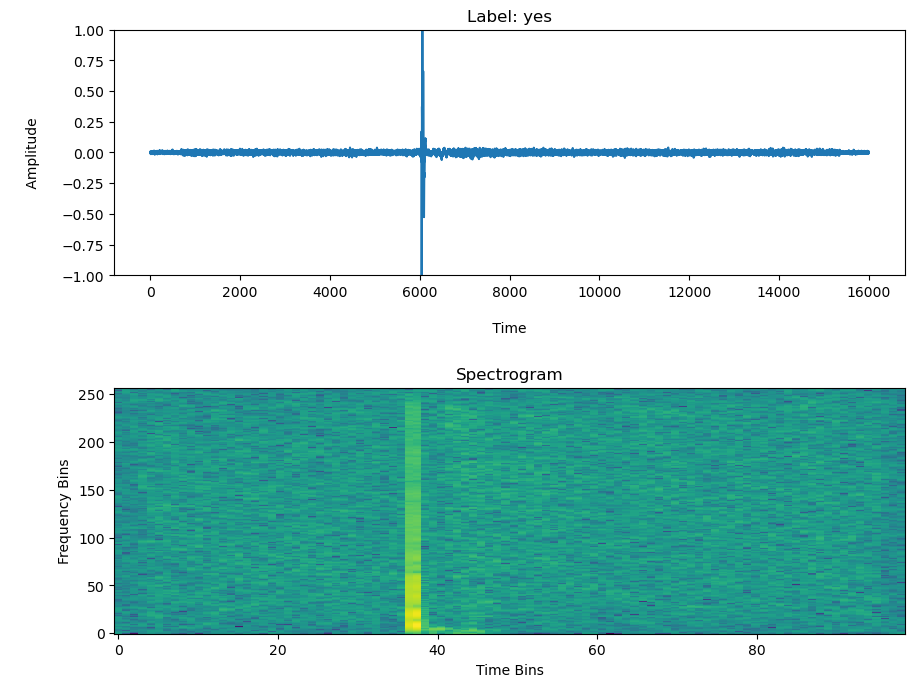

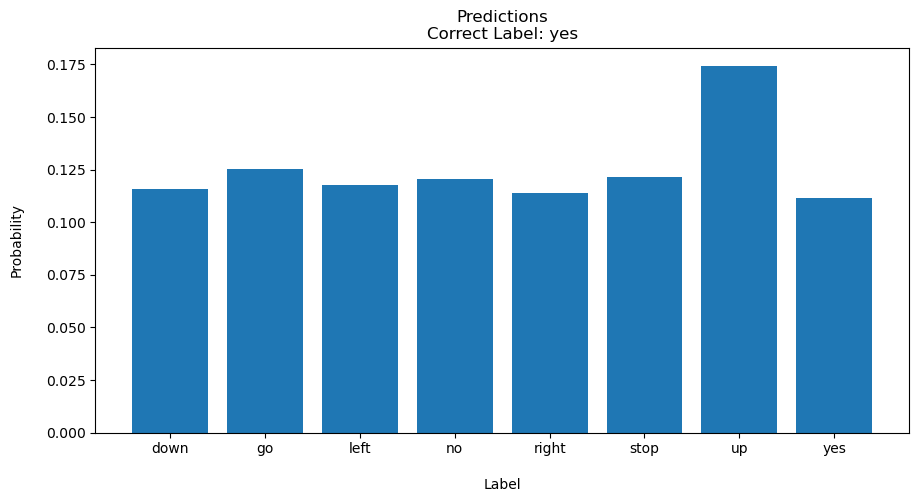

In [147]:
audio_pad = process_audio(audio_tensor)
print('Length of audio sample', len(audio_pad))

pred_label = get_prediction(model, audio_data = audio_pad, audio_label = 'yes', use_mfccs = False, plot_preds = True)
print(f'\n\nPredicted Label: {pred_label}\n')